In [371]:
import pandas as pd

# 讀取檔案
all_df = pd.read_csv("high_diamond_ranked_10min.csv")

# 刪除不必要的欄位
all_df = all_df.drop(
    [
        "gameId",
        "redGoldDiff",
        "redFirstBlood",
        "redAssists",
        "redExperienceDiff",
        "redCSPerMin",
        "redGoldPerMin",
        "blueCSPerMin",
        "blueGoldPerMin",
    ],
    axis=1,
)
all_df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redDeaths,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,9,0,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,5,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,1,0,...,7,0,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,1,0,1,...,4,0,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,6,1,1,0,0,17404,7.0,18313,225,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,7,0,0,0,0,15246,6.8,16498,229,34
9875,1,54,0,0,6,4,8,1,1,0,...,6,0,0,0,0,15456,7.0,18367,206,56
9876,0,23,1,0,6,7,5,0,0,0,...,6,1,1,0,0,18319,7.4,19909,261,60
9877,0,14,4,1,2,3,3,1,1,0,...,2,0,0,0,0,15298,7.2,18314,247,40


In [372]:
import numpy as np

mask = np.random.rand(len(all_df)) < 0.8
train_df = all_df[mask]
test_df = all_df[~mask]
len(test_df)

1934

In [373]:
from typing import Tuple
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical


def feature_preprocessing(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    # 把資料分開成特徵與標籤
    nd_array = df.values
    labels = nd_array[:, 0]  # 標籤
    data = nd_array[:, 1:]  # 特徵 

    # 特徵縮放成0~1之間
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # OHE: one-hot encoding
    labels = to_categorical(labels)

    return scaled_data, labels


train_data, train_labels = feature_preprocessing(train_df)
test_data, test_labels = feature_preprocessing(test_df)
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [479]:
"""
acc維持0.72
loss維持0.55
"""
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(3, input_dim=30, activation="softmax"))
# model.add(Dropout(0.2))
model.add(Dense(32, activation="softmax"))
# model.add(Dropout(0.2))
model.add(Dense(2, activation="sigmoid"))

# 使用 Adam 優化器
optimizer = Adam(lr=0.01)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

In [481]:
"""
acc維持0.72
loss快速從0.45掉到0.18
"""
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from keras import regularizers

model = Sequential()

model.add(Input(shape=(30,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l1(0.01)))
# model.add(Dense(16, activation="relu"))  # 修改隱藏層的神經元個數
model.add(Dense(2, activation="relu"))

sgd = SGD(lr=0.001, momentum=0.9)  # 調整學習率和動量
model.compile(optimizer="Adam", metrics=["acc"], loss="mean_squared_error")

In [591]:
"""
acc維持0.74
loss快速從0.45掉到0.18
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

model = Sequential()

model.add(Input(shape=(30,)))
model.add(Dense(19, activation="relu"))
model.add(Dense(19, activation="relu",kernel_regularizer=regularizers.l1(0.03)))
# model.add(Dense(16, activation="relu"))  # 修改隱藏層的神經元個數
model.add(Dense(2, activation="softmax"))

sgd = SGD(lr=0.93, momentum=0.97)  # 調整學習率和動量0.0086
model.compile(optimizer="ADAM", metrics=["acc"], loss="mean_squared_error")

Epoch 1/128
110/110 [==============================] - 0s 2ms/step - loss: 1.7839 - acc: 0.6238 - val_loss: 1.2873 - val_acc: 0.7128
Epoch 2/128
110/110 [==============================] - 0s 2ms/step - loss: 0.9286 - acc: 0.6978 - val_loss: 0.6225 - val_acc: 0.7138
Epoch 3/128
110/110 [==============================] - 0s 1ms/step - loss: 0.4365 - acc: 0.6948 - val_loss: 0.3037 - val_acc: 0.7002
Epoch 4/128
110/110 [==============================] - 0s 1ms/step - loss: 0.2559 - acc: 0.6869 - val_loss: 0.2387 - val_acc: 0.7013
Epoch 5/128
110/110 [==============================] - 0s 1ms/step - loss: 0.2331 - acc: 0.6910 - val_loss: 0.2312 - val_acc: 0.6992
Epoch 6/128
110/110 [==============================] - 0s 1ms/step - loss: 0.2252 - acc: 0.6965 - val_loss: 0.2236 - val_acc: 0.7075
Epoch 7/128
110/110 [==============================] - 0s 1ms/step - loss: 0.2202 - acc: 0.6966 - val_loss: 0.2192 - val_acc: 0.7138
Epoch 8/128
110/110 [==============================] - 0s 1ms/step - 

110/110 [==============================] - 0s 2ms/step - loss: 0.1878 - acc: 0.7307 - val_loss: 0.1896 - val_acc: 0.7275
Epoch 63/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1878 - acc: 0.7288 - val_loss: 0.1887 - val_acc: 0.7317
Epoch 64/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1879 - acc: 0.7265 - val_loss: 0.1888 - val_acc: 0.7348
Epoch 65/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1879 - acc: 0.7271 - val_loss: 0.1888 - val_acc: 0.7306
Epoch 66/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1876 - acc: 0.7271 - val_loss: 0.1885 - val_acc: 0.7317
Epoch 67/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1875 - acc: 0.7291 - val_loss: 0.1884 - val_acc: 0.7306
Epoch 68/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1875 - acc: 0.7265 - val_loss: 0.1878 - val_acc: 0.7421
Epoch 69/128
110/110 [==============================] - 0s 1ms/step - loss:

110/110 [==============================] - 0s 1ms/step - loss: 0.1847 - acc: 0.7285 - val_loss: 0.1854 - val_acc: 0.7358
Epoch 124/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1848 - acc: 0.7305 - val_loss: 0.1854 - val_acc: 0.7338
Epoch 125/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1848 - acc: 0.7311 - val_loss: 0.1853 - val_acc: 0.7379
Epoch 126/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1846 - acc: 0.7294 - val_loss: 0.1855 - val_acc: 0.7327
Epoch 127/128
110/110 [==============================] - 0s 1ms/step - loss: 0.1858 - acc: 0.7309 - val_loss: 0.1851 - val_acc: 0.7421
Epoch 128/128
110/110 [==============================] - 0s 2ms/step - loss: 0.1847 - acc: 0.7307 - val_loss: 0.1853 - val_acc: 0.7338


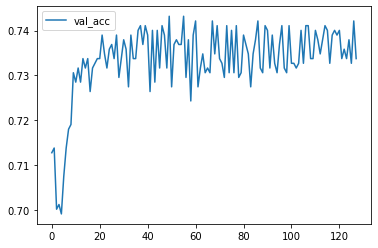

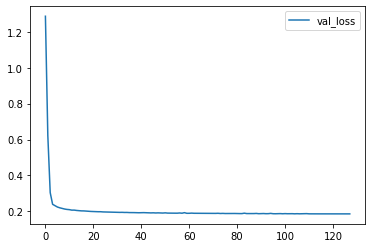

In [592]:
import matplotlib.pyplot as plt

history = model.fit(
    train_data, train_labels, validation_split=0.12, epochs=128, batch_size=64
)


# 輸出圖表
plt.plot(history.history["val_acc"], label="val_acc")
plt.legend()
plt.show()
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()